In [1]:
from __future__ import print_function

import keras
import keras.backend
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

## Create a generator of training batches

In [4]:
def get_X_y_from_df(solutions):
    X_raw = solutions.iloc[:,:-1].values
    y = solutions['cost'].values
    X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)
    return X, y

In [5]:
def process_batch(unused_row_idxs, batch_size):
    batch_row_idxs_mask_in_unused = np.zeros(len(unused_row_idxs), dtype=np.bool)
    batch_row_idxs_mask_in_unused[:batch_size] = 1
    np.random.shuffle(batch_row_idxs_mask_in_unused)
    batch_row_idxs_in_unused = np.argwhere(batch_row_idxs_mask_in_unused == 1).flatten()
    batch_row_idxs = unused_row_idxs[batch_row_idxs_in_unused]
    unused_row_idxs = np.delete(unused_row_idxs, batch_row_idxs_in_unused)
    return batch_row_idxs, unused_row_idxs

def train_batch_generator(csv_file_path, train_row_idxs_mask, batch_size, n_batches):
    batch_no = 0
    unused_row_idxs = np.argwhere(train_row_idxs_mask == 1).flatten()
    
    while batch_no < n_batches:
        batch_row_idxs, unused_row_idxs = process_batch(unused_row_idxs, batch_size)

        skiprows_mask = np.ones(len(train_row_idxs_mask), dtype=np.bool)
        skiprows_mask[batch_row_idxs] = 0
        skiprows_mask[0] = 0

        solutions = pd.read_csv(
             csv_file_path,
             header=0, 
             skiprows=lambda i: skiprows_mask[i])

        yield get_X_y_from_df(solutions)
        
        batch_no = batch_no + 1

In [6]:
def load_validation_data(csv_file_path, test_idxs_mask):
    skiprows_mask = np.invert(test_idxs_mask)
    skiprows_mask[0] = 0
    solutions = pd.read_csv(
             csv_file_path,
             header=0, 
             skiprows=lambda i: skiprows_mask[i])
    X_valid, y_valid = get_X_y_from_df(solutions)
    return X_valid, y_valid

In [7]:
def get_idxs_masks(n_rows_train, n_rows_test):
    n_rows_total = n_rows_train + n_rows_test
    train_idxs_mask = np.ones(n_rows_total, dtype=np.bool)
    train_idxs_mask[:n_rows_test] = 0
    np.random.shuffle(train_idxs_mask)
    test_idxs_mask = np.invert(train_idxs_mask)
    assert(train_idxs_mask.sum() == n_rows_train)
    assert(test_idxs_mask.sum() == n_rows_test)
    return train_idxs_mask, test_idxs_mask

In [8]:
N_ROWS_TOTAL = 98483266  # Includes the header row
TEST_SIZE_RATIO = 0.01
N_ROWS_TEST = int(N_ROWS_TOTAL * TEST_SIZE_RATIO)
N_ROWS_TRAIN = N_ROWS_TOTAL - N_ROWS_TEST

BATCH_SIZE = 4000000
N_BATCHES_PER_EPOCH = N_ROWS_TOTAL // BATCH_SIZE

CSV_FILE_PATH = f"/home/{os.environ.get('USER')}/code/fifteen-puzzle/data/datasets/solutions-large.csv"

In [9]:
train_idxs_mask, test_idxs_mask = get_idxs_masks(N_ROWS_TRAIN, N_ROWS_TEST)

In [10]:
def save_idxs_masks():
    import pickle

    with open('train_idxs_mask.pickle', 'wb') as handle:
        pickle.dump(train_idxs_mask, handle)

    with open('test_idxs_mask.pickle', 'wb') as handle:
        pickle.dump(test_idxs_mask, handle)

In [11]:
def load_idxs_masks():
    import pickle

    with open('train_idxs_mask.pickle', 'rb') as handle:
        train = pickle.load(handle)

    with open('test_idxs_mask.pickle', 'rb') as handle:
        test = pickle.load(handle)
        
    return train, test

In [10]:
# generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)

In [12]:
# train_idxs_mask, test_idxs_mask = load_idxs_masks()

In [10]:
X_valid, y_valid = load_validation_data(CSV_FILE_PATH, test_idxs_mask)

## Training

In [11]:
def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True):
    model = Sequential()
    model.add(Dense(layer_sizes[0], input_shape=(256,), activation=activation, kernel_initializer=kernel_initializer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio * 0.5))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation=activation, kernel_initializer=kernel_initializer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal'))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

In [15]:
import datetime

model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f'keras-1024-1024-512-128-64-v2_{datetime.datetime.now()}.h5')
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 257s 64us/step - loss: 16.4203 - acc: 0.1199 - val_loss: 3.6040 - val_acc: 0.1951
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 254s 63us/step - loss: 6.1286 - acc: 0.1617 - val_loss: 3.0059 - val_acc: 0.2309
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 252s 63us/step - loss: 4.6350 - acc: 0.1858 - val_loss: 2.6654 - val_acc: 0.2368
Train on 3999999 samples, validate on 984832 samples
Epoch 1/1
3999999/3999999 [==============================] - 237s 59us/step - loss: 4.2255 - acc: 0.1960 - val_loss: 2.5172 - val_acc: 0.2498
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 223s 56us/step - loss: 4.0549 - acc: 0.2005 - val_loss: 2.3305 - val_acc: 0.2543


ParserError: Error tokenizing data. C error: no error message set

In [16]:
import datetime

model = get_model([4096, 4096, 2048, 2048, 1024, 512, 256, 128], 
                  learning_rate=0.0005, 
                  dropout_ratio=0.3)

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f"keras-large-4096-4096-2048-2048-1024-512-256-128_{datetime.datetime.now()}.h5")
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 774s 193us/step - loss: 75.2416 - acc: 0.0993 - val_loss: 3.3887 - val_acc: 0.2248
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 770s 193us/step - loss: 11.1077 - acc: 0.1207 - val_loss: 2.8205 - val_acc: 0.2338


ParserError: Error tokenizing data. C error: no error message set

## First part of training

In [ ]:
import datetime

model = get_model([4096, 4096, 4096, 2048, 2048, 2048, 2048, 1024, 1024, 1024], 
                  learning_rate=0.0001, 
                  dropout_ratio=0.3)

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f"keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_{datetime.datetime.now()}.h5")
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1295s 324us/step - loss: 141.2361 - acc: 0.0913 - val_loss: 3.9740 - val_acc: 0.2175
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1288s 322us/step - loss: 8.9088 - acc: 0.1437 - val_loss: 3.1159 - val_acc: 0.2275
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1293s 323us/step - loss: 6.5126 - acc: 0.1613 - val_loss: 2.7866 - val_acc: 0.2354
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1290s 323us/step - loss: 5.5519 - acc: 0.1717 - val_loss: 2.5180 - val_acc: 0.2466
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1285s 321us/step - loss: 4.9769 - acc: 0.1797 - val_loss: 2.2996 - val_acc: 0.2645
Train on 4000

18 out of 24 batches were run.

## Second part of training

### Import and verify model

In [20]:
model = keras.models.load_model("keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-25 04:14:15.025421.h5")

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_valid)
mean_squared_error(y_pred, y_valid)

1.756599863771193

### Decrease the learning rate

In [25]:
keras.backend.get_value(model.optimizer.lr)

1e-04

In [26]:
keras.backend.set_value(model.optimizer.lr, 0.00001)
keras.backend.get_value(model.optimizer.lr)

1e-05

### Resume training

In [27]:
import datetime

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f"keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_{datetime.datetime.now()}.h5")
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1305s 326us/step - loss: 3.4699 - acc: 0.2137 - val_loss: 1.6536 - val_acc: 0.3105
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1311s 328us/step - loss: 3.4462 - acc: 0.2144 - val_loss: 1.6415 - val_acc: 0.3149
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1311s 328us/step - loss: 3.4391 - acc: 0.2146 - val_loss: 1.6305 - val_acc: 0.3162
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1308s 327us/step - loss: 3.8613 - acc: 0.2148 - val_loss: 1.6280 - val_acc: 0.3109
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1276s 319us/step - loss: 3.4143 - acc: 0.2155 - val_loss: 1.6248 - val_acc: 0.3112
Train on 400000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1190400/4000000 [=======>......................] - ETA: 14:21 - loss: 3.4022 - acc: 0.2156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 1273s 318us/step - loss: 3.4038 - acc: 0.2160 - val_loss: 1.5919 - val_acc: 0.3185
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1273s 318us/step - loss: 3.3698 - acc: 0.2172 - val_loss: 1.5877 - val_acc: 0.3190


RuntimeError: Unable to flush file's cached information (file write failed: time = Mon Mar 25 10:02:07 2019
, filename = 'keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-25 10:02:07.373705.h5', file descriptor = 64, errno = 28, error message = 'No space left on device', buf = 0x55f92da90cc0, total write size = 11040, bytes this sub-write = 11040, bytes actually written = 18446744073709551615, offset = 4096)

## Third part of training

In [20]:
model = keras.models.load_model("keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-25 09:39:23.560560.h5")

In [16]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_valid)
mean_squared_error(y_pred, y_valid)

1.591857800383701

In [21]:
keras.backend.get_value(model.optimizer.lr)

1e-05

In [22]:
import datetime

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f"keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_{datetime.datetime.now()}.h5")
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1319s 330us/step - loss: 3.3769 - acc: 0.2163 - val_loss: 1.5933 - val_acc: 0.3161
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1342s 335us/step - loss: 3.3679 - acc: 0.2171 - val_loss: 1.5888 - val_acc: 0.3183
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1357s 339us/step - loss: 3.3660 - acc: 0.2170 - val_loss: 1.5808 - val_acc: 0.3205
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1301s 325us/step - loss: 3.3505 - acc: 0.2180 - val_loss: 1.5815 - val_acc: 0.3212
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1282s 321us/step - loss: 3.3721 - acc: 0.2170 - val_loss: 1.5831 - val_acc: 0.3170
Train on 400000

## Fourth part of training

In [24]:
keras.backend.get_value(model.optimizer.lr)

1e-05

In [25]:
keras.backend.set_value(model.optimizer.lr, 0.00005)
keras.backend.get_value(model.optimizer.lr)

5e-05

In [26]:
import datetime

epoch = 1
try:
    while True:
        generator = train_batch_generator(CSV_FILE_PATH, train_idxs_mask, BATCH_SIZE, N_BATCHES_PER_EPOCH)
        for X_train, y_train in generator: 
            model.fit(X_train, y_train, 
                      batch_size=256,
                      epochs=1,
                      verbose=1,
                      validation_data=(X_valid, y_valid))
            model.save(f"keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_{datetime.datetime.now()}.h5")
        epoch = epoch + 1
except KeyboardInterrupt:
    pass

Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1293s 323us/step - loss: 3.4015 - acc: 0.2158 - val_loss: 1.6350 - val_acc: 0.3057
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1284s 321us/step - loss: 3.3964 - acc: 0.2165 - val_loss: 1.6177 - val_acc: 0.3102
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1281s 320us/step - loss: 3.3850 - acc: 0.2162 - val_loss: 1.6266 - val_acc: 0.3093
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1277s 319us/step - loss: 3.3770 - acc: 0.2166 - val_loss: 1.6017 - val_acc: 0.3188
Train on 4000000 samples, validate on 984832 samples
Epoch 1/1
4000000/4000000 [==============================] - 1280s 320us/step - loss: 3.3778 - acc: 0.2167 - val_loss: 1.5963 - val_acc: 0.3112
Train on 400000

RuntimeError: Unable to flush file's cached information (file write failed: time = Tue Mar 26 00:31:16 2019
, filename = 'keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-26 00:31:16.404914.h5', file descriptor = 64, errno = 28, error message = 'No space left on device', buf = 0x55ddca0a6a80, total write size = 11040, bytes this sub-write = 11040, bytes actually written = 18446744073709551615, offset = 4096)

In [ ]:
model = keras.models.load_model("keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-26 00:31:16.404914.h5")

In [ ]:
keras-large-4096-4096-4096-2048-2048-2048-1024-1024-1024_2019-03-26 00:31:16.404914.h5

## Legacy code

In [12]:
model = get_model([512, 256, 128], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4000000 samples, validate on 1000000 samples
Epoch 1/2
4000000/4000000 [==============================] - 158s 39us/step - loss: 11.9641 - acc: 0.1360 - val_loss: 3.3926 - val_acc: 0.2132
Epoch 2/2
4000000/4000000 [==============================] - 157s 39us/step - loss: 6.0351 - acc: 0.1618 - val_loss: 3.0711 - val_acc: 0.2184


In [14]:
model = get_model([1024, 256, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4000000 samples, validate on 1000000 samples
Epoch 1/2
4000000/4000000 [==============================] - 200s 50us/step - loss: 14.8466 - acc: 0.1240 - val_loss: 3.3457 - val_acc: 0.2239
Epoch 2/2
4000000/4000000 [==============================] - 195s 49us/step - loss: 5.7408 - acc: 0.1667 - val_loss: 2.7952 - val_acc: 0.2382


In [9]:
model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/2
4800000/4800000 [==============================] - 311s 65us/step - loss: 13.5032 - acc: 0.1289 - val_loss: 3.4299 - val_acc: 0.2158
Epoch 2/2
4800000/4800000 [==============================] - 319s 66us/step - loss: 5.1966 - acc: 0.1755 - val_loss: 2.6096 - val_acc: 0.2476


In [11]:
model.save('keras-1024-1024-512-128-64.h5')

In [16]:
model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2,
                  loss='mean_absolute_percentage_error')

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/2
4800000/4800000 [==============================] - 233s 48us/step - loss: 1557.2172 - acc: 0.1186 - val_loss: 423521.2604 - val_acc: 0.1561
Epoch 2/2
4800000/4800000 [==============================] - 230s 48us/step - loss: 2558.4671 - acc: 0.0931 - val_loss: 1869.0462 - val_acc: 0.1885


In [17]:
model.save('keras-1024-1024-512-128-64_mape.h5')

In [18]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/1
4800000/4800000 [==============================] - 230s 48us/step - loss: 7287.6247 - acc: 0.0878 - val_loss: 4.2608 - val_acc: 0.1933


In [19]:
model.save('keras-1024-1024-512-128-64_mape2.h5')

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/1
4800000/4800000 [==============================] - 263s 55us/step - loss: 2321.8209 - acc: 0.1173 - val_loss: 44997985.8582 - val_acc: 0.1750


In [23]:
model.save('keras-1024-1024-512-128-64_mape3.h5')

In [24]:
model = get_model([1024, 1024, 512, 128, 64], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2,
                  loss='mean_absolute_error')

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/2
4800000/4800000 [==============================] - 282s 59us/step - loss: 2.5457 - acc: 0.1316 - val_loss: 1.4757 - val_acc: 0.2082
Epoch 2/2
4800000/4800000 [==============================] - 279s 58us/step - loss: 1.8285 - acc: 0.1742 - val_loss: 1.4870 - val_acc: 0.1991


In [27]:
model.save('keras-1024-1024-512-128-64_mae.h5')

In [28]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/2
4800000/4800000 [==============================] - 276s 57us/step - loss: 1.6753 - acc: 0.1915 - val_loss: 1.3044 - val_acc: 0.2453
Epoch 2/2
4800000/4800000 [==============================] - 276s 57us/step - loss: 1.6310 - acc: 0.1977 - val_loss: 1.4081 - val_acc: 0.2099


In [29]:
model.save('keras-1024-1024-512-128-64_mae.h5')

In [31]:
model = get_model([2048, 2048, 1024, 512, 256, 128], 
                  learning_rate=0.01, 
                  dropout_ratio=0.2)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/2
4800000/4800000 [==============================] - 370s 77us/step - loss: 10.8468 - acc: 0.1411 - val_loss: 3.1935 - val_acc: 0.2217
Epoch 2/2
4800000/4800000 [==============================] - 366s 76us/step - loss: 5.3088 - acc: 0.1727 - val_loss: 3.5829 - val_acc: 0.2167


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Train on 4800000 samples, validate on 1200000 samples
Epoch 1/1
  60160/4800000 [..............................] - ETA: 6:11 - loss: 4.4502 - acc: 0.1863

In [32]:
history.history['val_loss'][-1]

5.009056898193359

In [33]:
arr = np.array([15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [26]:
# X_valid[0].reshape(1, -1)
X_valid[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
model.predict(X_valid[0].reshape(1, -1)).item()

36.97019958496094

In [25]:
y_pred = model.predict(X_valid)

In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_pred, y_valid)

3.3344361351995495

In [15]:
predictions = pd.DataFrame({'predicted': y_pred.flatten(), 'real': y_valid.flatten()})
predictions['difference'] = predictions['predicted'] - predictions['real']

In [16]:
predictions['difference'].max()

10.624881744384766

In [17]:
predictions['difference'].quantile(0.99)

5.203792724609379

In [18]:
predictions['difference'].describe()

count    200000.000000
mean         -0.121780
std           2.234782
min          -9.608101
25%          -1.726406
50%          -0.271679
75%           1.396399
max          10.624882
Name: difference, dtype: float64

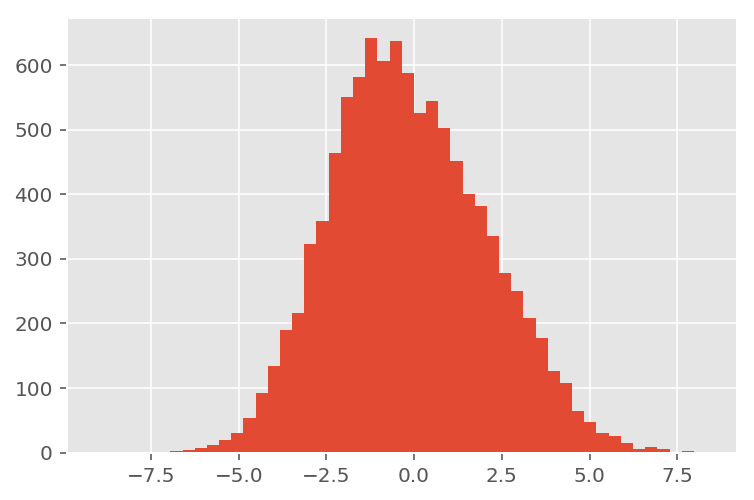

In [19]:
predictions['difference'].sample(10000).hist(bins=50);

In [33]:
predictions.head(15)

,predicted,real,difference
0,43.336647,40,3.336647
1,48.727898,49,-0.272102
2,51.447117,51,0.447117
3,42.822010,44,-1.177990
4,22.060034,21,1.060034
5,50.969612,50,0.969612
6,38.290455,40,-1.709545
7,54.615852,55,-0.384148
8,30.009943,33,-2.990057
9,45.195145,46,-0.804855


In [32]:
predictions[predictions.real < 10].head(15)

,predicted,real,difference
1147,6.510941,4,2.510941
1395,7.607174,7,0.607174
4936,10.983410,9,1.983410
10571,9.789221,8,1.789221
10755,10.208565,9,1.208565
11722,9.288631,8,1.288631
12007,10.361462,8,2.361462
17918,10.325645,9,1.325645
18558,9.967926,9,0.967926
18679,10.692951,8,2.692951


In [23]:
def benchmark(layer_sizes, epochs=10, dropout_ratio=0.2):
    histories = []

    for layers in layer_sizes:
        model = get_model(layers, dropout_ratio=dropout_ratio)
        history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
        histories.append(history)
        
    return histories

In [24]:
def plot_histories(histories, layer_sizes, metric_name='val_acc'):
    accuracy_histories = [history.history[metric_name] for history in histories]

    plt.figure(figsize=(14,10))

    for accuracy_history in accuracy_histories:
        plt.plot(accuracy_history, linewidth=3)

    labels = [str(layers) for layers in layer_sizes]
    plt.legend(labels);

In [151]:
layer_sizes = [
    [256, 128, 64],
    [512, 256, 128],
    [512, 256, 128, 64]
]

histories = benchmark(layer_sizes, epochs=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 138us/step - loss: 0.3916 - acc: 0.8814 - val_loss: 0.1312 - val_acc: 0.9609
Epoch 2/100
60000/60000 [==============================] - 5s 86us/step - loss: 0.1533 - acc: 0.9546 - val_loss: 0.0952 - val_acc: 0.9713
Epoch 3/100
60000/60000 [==============================] - 5s 85us/step - loss: 0.1154 - acc: 0.9659 - val_loss: 0.0890 - val_acc: 0.9727
Epoch 4/100
60000/60000 [==============================] - 5s 87us/step - loss: 0.0939 - acc: 0.9720 - val_loss: 0.0814 - val_acc: 0.9761
Epoch 5/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.0813 - acc: 0.9758 - val_loss: 0.0678 - val_acc: 0.9794
Epoch 6/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.0685 - acc: 0.9794 - val_loss: 0.0716 - val_acc: 0.9788
Epoch 7/100
60000/60000 [==============================] - 5s 90us/step - loss: 0.0614 - acc: 0.9810 - val_loss: 0.0775 -

60000/60000 [==============================] - 8s 130us/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0761 - val_acc: 0.9827
Epoch 18/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.0213 - acc: 0.9931 - val_loss: 0.0630 - val_acc: 0.9852
Epoch 19/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0855 - val_acc: 0.9807
Epoch 20/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0216 - acc: 0.9933 - val_loss: 0.0682 - val_acc: 0.9834
Epoch 21/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.0189 - acc: 0.9942 - val_loss: 0.0747 - val_acc: 0.9826
Epoch 22/100
60000/60000 [==============================] - 8s 138us/step - loss: 0.0199 - acc: 0.9937 - val_loss: 0.0647 - val_acc: 0.9849
Epoch 23/100
60000/60000 [==============================] - 8s 134us/step - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0740 - val_acc: 0.9832
Epoch 24/100
60000/60000 [=======

60000/60000 [==============================] - 9s 148us/step - loss: 0.0154 - acc: 0.9954 - val_loss: 0.0762 - val_acc: 0.9847
Epoch 34/100
60000/60000 [==============================] - 9s 146us/step - loss: 0.0128 - acc: 0.9962 - val_loss: 0.0945 - val_acc: 0.9829
Epoch 35/100
60000/60000 [==============================] - 9s 143us/step - loss: 0.0133 - acc: 0.9961 - val_loss: 0.0945 - val_acc: 0.9832
Epoch 36/100
60000/60000 [==============================] - 9s 143us/step - loss: 0.0157 - acc: 0.9956 - val_loss: 0.0841 - val_acc: 0.9814
Epoch 37/100
60000/60000 [==============================] - 9s 144us/step - loss: 0.0136 - acc: 0.9961 - val_loss: 0.0765 - val_acc: 0.9854
Epoch 38/100
60000/60000 [==============================] - 9s 150us/step - loss: 0.0149 - acc: 0.9958 - val_loss: 0.1054 - val_acc: 0.9803
Epoch 39/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.0142 - acc: 0.9958 - val_loss: 0.1122 - val_acc: 0.9816
Epoch 40/100
60000/60000 [=======

TypeError: plot_histories() missing 1 required positional argument: 'layer_sizes'

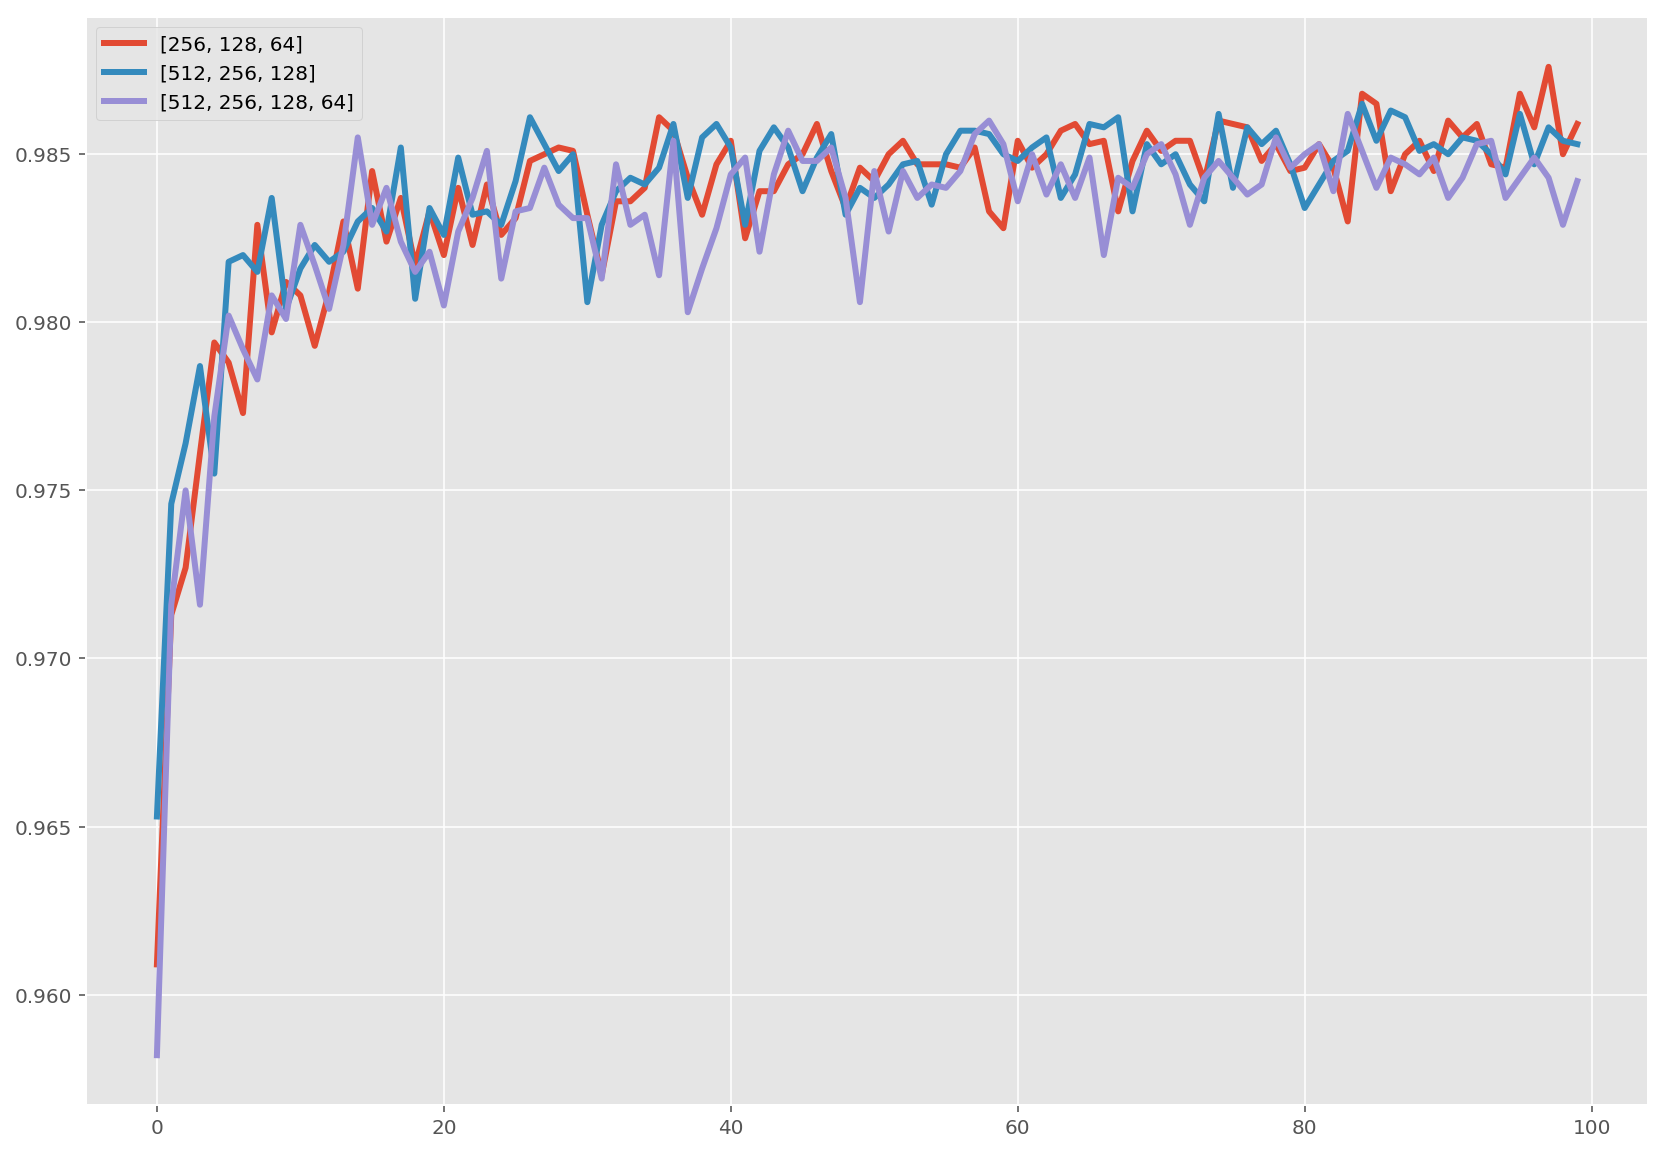

In [155]:
plot_histories(histories, layer_sizes, 'val_acc')